# Scraper:  poets.org

The website `poets.org` contains mostly contemporary poetry of a decidedly serious cast.  While I like the poetry contained here, it was not clear to me to what extent it would lend itself to the photobooking application I was thinking about.  One of the great virtues of this website, however, is that it is possible to search for poems by both "theme" and "occasion".  Below I use this search capacity to scrape both the poems and their associated theme/occasion tags.  This gives me a labeled set of data which I can use for supervised learning.

This script is divided into two parts:

1.  <a href='#scraping'> Scraping </a>
2.  <a href='#cleaning'> Cleaning </a>

----

<a id='scraping'></a>
## Part I:  Scraping

**Path and file names**

In [2]:
rootdir = "../data/poems"         # root directory for all poetry data
csvdir   = rootdir + '/csv'       # subdirectory for csv files
pkldir   = rootdir + '/pkl'       # subdirectory for pkl files
main_website = "https://www.poets.org" # base url
poem_subpage = "/poetsorg/poems"   # landing page for the poem search and browse functions
rawpoems_fname = 'poetsorg_raw'      # base name of variables and files containing raw, uncleaned poems
cleanpoems_fname = 'poetsorg_clean'  # base name for cleaned poems
url_fname = 'poetsorg_urls'        # temporary file for storing urls

**Import statements:**

In [3]:
from bs4 import BeautifulSoup
import numpy as np
import requests
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import os
%matplotlib inline

**Connect:**

In [27]:
main = requests.get(main_website + poem_subpage)
main_soup = BeautifulSoup(main.text,'lxml')  

Scrape urls of landing page for each theme 

In [28]:
theme_urls = []
for theme in main_soup.find_all('div',class_="themes")[0].find_all('li'):
    theme_url = theme.contents[0].get('href')
    theme_name = theme.get_text()
    theme_urls.append([theme_url,theme_name])
    
df_themes = pd.DataFrame(theme_urls,columns=['url','theme'])
df_themes[0:15]

,url,theme
0,/poetsorg/poems?field_poem_themes_tid=851,Afterlife
1,/poetsorg/poems?field_poem_themes_tid=856,Aging
2,/poetsorg/poems?field_poem_themes_tid=861,Ambition
3,/poetsorg/poems?field_poem_themes_tid=866,America
4,/poetsorg/poems?field_poem_themes_tid=871,American Revolution
5,/poetsorg/poems?field_poem_themes_tid=1691,Americana
6,/poetsorg/poems?field_poem_themes_tid=876,Ancestry
7,/poetsorg/poems?field_poem_themes_tid=881,Anger
8,/poetsorg/poems?field_poem_themes_tid=886,Animals
9,/poetsorg/poems?field_poem_themes_tid=1531,Anxiety


*Audio* as actually not a theme...it just means that there is an audio recording of this poem.  Since this fact is irrelevant for this classification scheme, we'll drop that row.  Ditto for *Public domain*.

In [7]:
df_themes = df_themes.loc[(df_themes.theme != 'Audio') & (df_themes.theme != 'Public Domain'),:]

*Optional:* Scrape url of landing page for each occasion. (I didn't actually use these, but someone might want to, so I've kept the code here.)

In [8]:
occasion_urls = []
for occasion in main_soup.find_all('div',class_="occasions")[0].find_all('li'):
    occasion_url = occasion.contents[0].get('href')
    occasion_name = occasion.get_text()
    occasion_urls.append([occasion_url,occasion_name])
    
df_occasions = pd.DataFrame(occasion_urls,columns=['url','occasion'])
df_occasions.head()

,url,occasion
0,/poetsorg/poems?field_occasion_tid=476,Anniversary
1,/poetsorg/poems?field_occasion_tid=1671,Asian/Pacific American Heritage Month
2,/poetsorg/poems?field_occasion_tid=484,Autumn
3,/poetsorg/poems?field_occasion_tid=478,Birthdays
4,/poetsorg/poems?field_occasion_tid=1501,Black History Month


**Gather the urls of all poems for each theme**

Now build a master list of poem/theme combinations.  This involves some clever webscraping...for each theme, the results are displayed in a variable number of pages.  We need to figure out the number of pages, and use that number to predict the urls of the pages listing poems ('landing pages').  Once we have these landing pages, we scrape poem info from them.

In order to implement this scheme, we'll need a helper function that returns the individual poem urls from each landing subpage for a given theme.

In [12]:
def get_poem_urls(landing_page_url,theme):
    '''assemble list of poems from a landing page''' 
    year_title_url_poet_theme = []
    main = requests.get(landing_page_url)
    main_soup = BeautifulSoup(main.text,'lxml') 
    odd_entries = main_soup.find_all('tr', class_="odd")
    even_entries = main_soup.find_all('tr', class_="even")
    all_entries = odd_entries + even_entries
    for entry in all_entries:
        year = entry.find('span',class_="date-display-single")
        if year:
            year = year.get_text()
        else:
            year = ''
        titleblob = entry.find('td',class_="views-field views-field-title")
        title = titleblob.a.get_text()
        poem_url = titleblob.a.get('href')
        poet = entry.find('td',class_="views-field views-field-field-first-name")
        if poet.find('a'):
            poet = poet.a.get_text()
        else:
            poet = ''
        year_title_url_poet_theme.append([year,title,poem_url,poet,theme])

    return year_title_url_poet_theme

We'll also need to write to files.  The following functions provide a little error checking to make sure we don't overwrite stuff.

In [13]:
def modify_filename(filename):
    """Add .bak suffix to string """
    return filename + '.bak'

def check_filename(filename):
    """If file that we're going to write to already exists, resave it with a .bak extension"""
    if os.path.isfile(filename):
        filename_mod = modify_filename(filename)
        while os.path.isfile(filename_mod):
            filename_mod = modify_filename(filename_mod)
        os.rename(filename,filename_mod)

Now we'll simply crawl along each theme, and for each theme crawl along each page, and for each page grab all the poem info.  To manage store, we'll write the output for each page to a file as we go along.

<span style="color:red"> Caution:</span> this cell takes a while to run (on the order of half an hour for all themes, but it goes much faster for just a subset.)

In [29]:
# define output file, and rename if it already exists
outfile = url_fname + '.csv'
check_filename(outfile)

# comment this section out if you want all themes
theme_subset = ['Cities','Nature','Love']
df_themes = df_themes.loc[df_themes.theme.isin(theme_subset)]

# for each theme....
for index, row in df_themes.iterrows():
    url = main_website + row['url']
    theme = row['theme']
    
    # ...figure out how many pages of output there are
    main = requests.get(url)
    main_soup = BeautifulSoup(main.text,'lxml') 
    npages=main_soup.find('li',class_="pager-item last")
    if npages:
        npages = npages.get_text()
    else:
        npages=main_soup.find('li',class_="pager-last last")
        if npages:
            npages = npages = npages.get_text()
        else:
            npages = 1
    npages_int = int(npages)
    
    # then extract the urls for each page, and print the theme for monitoring
    page_urls = [url, theme]
    print('theme:  ',theme)
    
    # then run over each such page and get the poem urls
    for i in np.arange(1,npages_int):
        page_url = url + "&page=" + str(i)
        page_content = get_poem_urls(page_url,theme)
        df_page = pd.DataFrame(page_content,columns=['year','title','url','author','theme'])
        
        # writing to disc after each page.
        with open(outfile, 'a') as f:
            df_page.to_csv(f, header=False,index=False)

theme:   Cities
theme:   Love
theme:   Nature


Finally, read in the output as a dataframe, add headers, and resave as a csv. 

In [ ]:
df_poetsorg_urls = pd.read_csv(outfile,names=['year','title','url','author','theme'])
df_poetsorg_urls.to_csv(outfile,index=False)

In [22]:
print('number of (perhaps non-distinct) poems', len(df_poetsorg_urls))
df_poetsorg_urls.head()

number of (perhaps non-distinct) poems 858


,year,title,url,author,theme
0,2017.0,Sea Change,/poetsorg/poem/sea-change,Sasha Pimentel,Cities
1,2009.0,The City Outside My Ear,/poetsorg/poem/city-outside-my-ear,Michael Luis Medrano,Cities
2,1922.0,On Broadway,/poetsorg/poem/broadway-0,Claude McKay,Cities
3,1917.0,"[London, my beautiful]",/poetsorg/poem/london-my-beautiful,F. S. Flint,Cities
4,1919.0,Solitare,/poetsorg/poem/solitare,Amy Lowell,Cities


**Drop redundant poems**

Some poems belong to more than one theme.  It makes no sense to re-scrape them.  So we need to re-arrange the data a bit.  We'll gather it by URL, and store themes as a list.

In [17]:
df_poetsorg_urls.set_index('url',inplace=True)
df_poetsorg_urls['themes'] = df_poetsorg_urls.groupby('url').apply(lambda x: x.theme.tolist())
df_poetsorg_urls.reset_index(inplace=True)
df_poetsorg_urls.drop_duplicates(subset='url',inplace=True)
del df_poetsorg_urls['theme']
print("number of unique poems: ", len(df_poetsorg_urls))
df_poetsorg_urls.head(3)

number of unique poems:  5497


,url,year,title,author,poem,themes
0,/poetsorg/poem/dark-tree-cold-sea,2017.0,"the dark tree, the cold sea",Emily Fragos,although I know you can never be found althoug...,[Afterlife]
1,/poetsorg/poem/populating-heaven,2008.0,Populating Heaven,Maureen N. McLane,"\r\n If we belonged \r\nto the dead, i...",[Afterlife]
2,/poetsorg/poem/night-migrations,2006.0,The Night Migrations,Louise Glück,This is the moment when you see again\nthe red...,"[Afterlife, Nature, Night, Plants]"


**Gather the poems from each poem url**

OK, now we've assembled an exhaustive list of poem urls, we can scrape the poems themselves!  This will really take a long time:  there are over 10000 labelled poems.  (*Suggestion:  run the cell just before you go to bed and check it in the morning.*)

The script writes poems to file every so often.  You can adjust how often it writes and prints out progress information. 



In [30]:
# define batch size for writing to file and printing progress
batchsize=10
outfile = rawpoems_fname + '.csv'
check_filename(outfile)

# create a dataframe to hold the poems, indexed by url
df_poetsorg_poems = pd.DataFrame(columns=['url','poem'])
df_poetsorg_poems['url']=df_poetsorg_urls['url']
df_poetsorg_poems.reset_index(inplace=True,drop=True)
jobsize = np.floor(len(df_poetsorg_poems)/batchsize)

# iterate over all poems
counter = 0
for row in df_poetsorg_poems.itertuples():
    
    # connecting poem page
    url = main_website + row.url
    main = requests.get(url)
    main_soup = BeautifulSoup(main.text,'lxml') 

    # finding the relevant div snippet, printing error message if we can't find it
    poem_div=main_soup.find('div',class_="field field-name-body field-type-text-with-summary field-label-hidden")
    if poem_div:
        text = poem_div.get_text(" ")
    else:
        print('missed {}'.format(url))
        
    # store poem in dataframe
    df_poetsorg_poems.loc[row.Index,'poem'] = text
    
    counter+=1
    #every batch, write to file and print out counter 
    if np.mod(counter,batchsize)==0:
        with open(outfile, 'a') as f:
            df_poetsorg_poems[counter-batchsize:counter].to_csv(f, header=False,index=False)
        print("completed {:1.0f} of {:1.0f} batches. ".format(counter/batchsize,jobsize))

# one last print statement to get residuals
with open(outfile, 'a') as f:
            df_poetsorg_poems[counter-np.mod(counter,batchsize):counter+1].to_csv(f, header=False,index=False)

completed 1 of 83 batches. 
completed 2 of 83 batches. 
completed 3 of 83 batches. 
completed 4 of 83 batches. 
completed 5 of 83 batches. 
completed 6 of 83 batches. 
completed 7 of 83 batches. 
completed 8 of 83 batches. 
completed 9 of 83 batches. 
completed 10 of 83 batches. 
completed 11 of 83 batches. 
completed 12 of 83 batches. 
completed 13 of 83 batches. 
completed 14 of 83 batches. 
completed 15 of 83 batches. 
completed 16 of 83 batches. 
completed 17 of 83 batches. 
completed 18 of 83 batches. 
completed 19 of 83 batches. 
completed 20 of 83 batches. 
completed 21 of 83 batches. 
completed 22 of 83 batches. 
completed 23 of 83 batches. 
completed 24 of 83 batches. 
completed 25 of 83 batches. 
completed 26 of 83 batches. 
completed 27 of 83 batches. 
completed 28 of 83 batches. 
completed 29 of 83 batches. 
completed 30 of 83 batches. 
completed 31 of 83 batches. 
completed 32 of 83 batches. 
completed 33 of 83 batches. 
completed 34 of 83 batches. 
completed 35 of 83 batc

We've already written these poems to a CSV file, but let's join the poems to the authors, titles, etc, and re-write the whole thing to include a header.  Let's also store the dataframe a pickle file.   Note that linebreaks are saved.  These might be useful for subsequent formatting, but will need to be cleaned out for processing.

In [31]:
df_rawpoems = pd.merge(df_poetsorg_urls,df_poetsorg_poems, on='url',left_index=True,right_index=True,how='inner')
df_rawpoems.head()

,year,title,url,author,themes,poem
0,2017.0,Sea Change,/poetsorg/poem/sea-change,Sasha Pimentel,[Cities],"Morning, and light seams\nthrough Juárez, its..."
1,2009.0,The City Outside My Ear,/poetsorg/poem/city-outside-my-ear,Michael Luis Medrano,[Cities],A Minnesota poet who writes in a plethora of i...
2,1922.0,On Broadway,/poetsorg/poem/broadway-0,Claude McKay,[Cities],About me young and careless feet Linger along ...
3,1917.0,"[London, my beautiful]",/poetsorg/poem/london-my-beautiful,F. S. Flint,[Cities],"London, my beautiful, it is not the sunset nor..."
4,1919.0,Solitare,/poetsorg/poem/solitare,Amy Lowell,[Cities],When night drifts along the streets of the cit...


In [19]:
# save the poems
df_rawpoems.to_pickle(pkldir + '/' + rawpoems_fname + '.pkl')
df_rawpoems.to_csv(csvdir + '/' + rawpoems_fname + '.csv',index=False)

<a id='cleaning'></a>
## Part II:  Cleaning

**Load the data**:  Structured this way so that one can clean the data without neeeding to scrape it.  

In [16]:
#df_cleanpoems = pd.read_pickle(pkldir + '/' + rawpoems_fname + '.pkl')
df_rawpoems = pd.read_pickle(pkldir + '/' + rawpoems_fname + '.pkl')
print("length of data:  ", len(df_cleanpoems))
#df_cleanpoems.head()
df_rawpoems.head()

length of data:   10360


,year,title,url,author,theme,poem
0,2017.0,"the dark tree, the cold sea",/poetsorg/poem/dark-tree-cold-sea,Emily Fragos,Afterlife,although I know you can never be found althoug...
1,2008.0,Populating Heaven,/poetsorg/poem/populating-heaven,Maureen N. McLane,Afterlife,"\r\n If we belonged \r\nto the dead, i..."
2,2006.0,The Night Migrations,/poetsorg/poem/night-migrations,Louise Glück,Afterlife,This is the moment when you see again\nthe red...
3,2004.0,Father Lynch Returns from the Dead,/poetsorg/poem/father-lynch-returns-dead,Jean Valentine,Afterlife,"There's one day a year\nthey can return, \nif ..."
4,1998.0,I heard a Fly buzz (465),/poetsorg/poem/i-heard-fly-buzz-465,Emily Dickinson,Afterlife,I heard a Fly buzz – when I died – \nThe Stil...


**Drop NAs**.  

In [164]:
df_cleanpoems = df_cleanpoems.dropna(axis=0,subset=['themes','poem','author'],how='any')
len(df_cleanpoems)

5461

Also make sure to remove any nas that may have crept into the composite theme list.

In [ ]:
df_cleanpoems.themes=df_cleanpoems.themes.apply(lambda x: [s for s in x if str(s)!='nan'])

**Remove carriage returns.**

In [165]:
df_cleanpoems = df_cleanpoems.replace({r'\r|\n': ' '}, regex=True)
df_cleanpoems.poem = df_cleanpoems.poem.str.strip()
df_cleanpoems.poem.head()

0    although I know you can never be found althoug...
1    If we belonged   to the dead, if we had our ow...
2    This is the moment when you see again the red ...
3    There's one day a year they can return,  if th...
4    I heard a Fly buzz – when I died –   The Still...
Name: poem, dtype: object

**Encode to ascii**

In [166]:
text_fields = ['poem','title','author']
for field in text_fields:
    df_cleanpoems[field]=df_cleanpoems[field].apply(lambda x:  x.encode("ascii",errors='ignore').decode())
    df_cleanpoems[field]=df_cleanpoems[field].str.strip()
df_cleanpoems.head(3)

,url,year,title,author,poem,themes
0,/poetsorg/poem/dark-tree-cold-sea,2017.0,"the dark tree, the cold sea",Emily Fragos,although I know you can never be found althoug...,[Afterlife]
1,/poetsorg/poem/populating-heaven,2008.0,Populating Heaven,Maureen N. McLane,"If we belonged to the dead, if we had our ow...",[Afterlife]
2,/poetsorg/poem/night-migrations,2006.0,The Night Migrations,Louise Glck,This is the moment when you see again the red ...,"[Afterlife, Nature, Night, Plants]"


**Calculate poems lengths**

(array([ 82.,  28.,  40.,  72., 111., 152., 149., 201., 249., 215., 275.,
        331., 252., 236., 238., 188., 185., 155., 152., 134.]),
 array([  1. ,  10.9,  20.8,  30.7,  40.6,  50.5,  60.4,  70.3,  80.2,
         90.1, 100. , 109.9, 119.8, 129.7, 139.6, 149.5, 159.4, 169.3,
        179.2, 189.1, 199. ]),
 <a list of 20 Patch objects>)

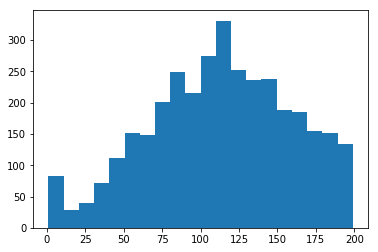

In [167]:
# calculate length for each poem, and plot it in a histogram
df_cleanpoems['lengths'] = df_cleanpoems.poem.str.split(' ').apply(lambda x: len(x))
plt.hist(df_cleanpoems.lengths.loc[df_cleanpoems.lengths<200],20)

**Troubleshooting**:  Seems strange that there are poems of length less than 25 words.  Let's investigate.

In [168]:
temp=df_cleanpoems.loc[df_cleanpoems.lengths<25,:]
temp

,url,year,title,author,poem,themes,lengths
11,/poetsorg/poem/wild-iris-audio-only,1992.0,The Wild Iris (audio only),Louise Glck,Click the icon above to listen to this audio p...,"[Afterlife, Flowers, For Teens, Loss]",10
74,/poetsorg/poem/edges-time-audio-only,2007.0,The Edges of Time (audio only),Kay Ryan,Click the icon above to listen to this audio p...,"[Aging, Time]",10
317,/poetsorg/poem/abraham-lincoln,1824.0,Abraham Lincoln,Abraham Lincoln,Abraham Lincoln his hand and pen he will be go...,[America],14
332,/poetsorg/poem/we-heard-health-care-audio-only,2011.0,We Heard Health Care (audio only),Claudia Rankine,Click the icon above to listen to this audio p...,[America],10
359,/poetsorg/poem/saturday-91501,2017.0,Saturday 9/15/01,Lucille Clifton,,"[America, Religion, Religion]",1
360,/poetsorg/poem/monday-sundown-91701,2017.0,Monday Sundown 9/17/01,Lucille Clifton,,"[America, History]",1
361,/poetsorg/poem/sunday-morning-91601,2017.0,Sunday Morning 9/16/01,Lucille Clifton,,"[America, History, War]",1
365,/poetsorg/poem/thursday-91301,2017.0,Thursday 9/13/01,Lucille Clifton,,"[America, War]",1
366,/poetsorg/poem/wednesday-91201,2017.0,Wednesday 9/12/01,Lucille Clifton,,"[America, Loss, War]",1
379,/poetsorg/poem/friday-91401,2017.0,Friday 9/14/01,Lucille Clifton,,"[America, Despair, Despair, History]",1


OK, looks like our scraping failed in a few cases.  Let's drop the failed ones.

In [169]:
suspecttext = temp.poem.unique().tolist()
suspecttext

['Click the icon above to listen to this audio poem.',
 'Abraham Lincoln his hand and pen he will be good but god knows When',
 '',
 'View this poem as a PDF >',
 "I never saw a Purple Cow, I never hope to see one, But I can tell you, anyhow, I'd rather see than be one!",
 'Over the shop where silk is sold Still the dragon kites are flying.',
 'The apparition of these faces in the crowd; Petals on a wet, black bough.',
 'The petals fall in the fountain,  the orange coloured rose-leaves, Their ochre clings to the stone.',
 'Ojibwa   The owl,  Au  The owl  Au  The great black  Owl  Au  Hi! a! haa!',
 "Yes  Yes  I see it so they won't keep telling you  where it is",
 'the round spoon with the curvature of a concave mirror scoops out my eye and swallows it',
 'I know Not these my hands And yet I think there was A woman like me once had hands Like these.',
 'My life has been the poem I would have writ But I could not both live and utter it.',
 'one narcissus draws close to another like the 

Most are legit, but some are obviously bad. 

In [170]:
badtext = ['Click the icon above to listen to this audio poem.','','View this poem as a PDF >','DISABLE SPELLCHECK']
df_cleanpoems = df_cleanpoems.drop(df_cleanpoems[df_cleanpoems.poem.isin(badtext)].index)
len(df_cleanpoems)

5382

In [171]:
df_cleanpoems.head()

,url,year,title,author,poem,themes,lengths
0,/poetsorg/poem/dark-tree-cold-sea,2017.0,"the dark tree, the cold sea",Emily Fragos,although I know you can never be found althoug...,[Afterlife],108
1,/poetsorg/poem/populating-heaven,2008.0,Populating Heaven,Maureen N. McLane,"If we belonged to the dead, if we had our ow...",[Afterlife],253
2,/poetsorg/poem/night-migrations,2006.0,The Night Migrations,Louise Glck,This is the moment when you see again the red ...,"[Afterlife, Nature, Night, Plants]",75
3,/poetsorg/poem/father-lynch-returns-dead,2004.0,Father Lynch Returns from the Dead,Jean Valentine,"There's one day a year they can return, if th...","[Afterlife, Death, Death]",49
4,/poetsorg/poem/i-heard-fly-buzz-465,1998.0,I heard a Fly buzz (465),Emily Dickinson,I heard a Fly buzzwhen I died The Stillness i...,[Afterlife],93


**Save and exit**

In [207]:
# save the poems
df_cleanpoems.to_pickle(pkldir + '/' + cleanpoems_fname + '.pkl')
df_cleanpoems.to_csv(csvdir + '/' + cleanpoems_fname + '.csv',index=False)